In [1]:
!pip install msmbuilder2022
!pip install numpy==1.23.5
!pip install matplotlib
!pip install scipy
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install tqdm

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
!curl -L https://uwmadison.box.com/shared/static/1y12gymo0tkc5dn3nihhqwzikxa8wzen --output oasis_trajs.npy
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/decomposition/VAMPNet_SRVNet_v2.py
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/quasi-MSM/qmsm.py
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/IGME/igme.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    10    0    10    0     0      9      0 --:--:--  0:00:01 --:--:--    11
100 2328M  100 2328M    0     0  65.4M      0  0:00:35  0:00:35 --:--:-- 32.2M
--2024-08-14 01:54:58--  https://github.com/xuhuihuang/GME_tutorials/raw/main/decomposition/VAMPNet_SRVNet_v2.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/decomposition/VAMPNet_SRVNet_v2.py [following]
--2024-08-14 01:54:58--  https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/decomposition/VAMPNet_SRVNet_v2.p

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import KMeans, KCenters, MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
from msmbuilder.lumping import PCCAPlus
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import *

from VAMPNet_SRVNet_v2 import *
from igme import IGMENS, IGME
from qmsm import QuasiMSM, MSM

In [4]:
oasis_trajs = np.load('oasis_trajs.npy', allow_pickle=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

## Set the random seed to ensure the reproducible training (not necessary)
set_random_seed(45)

network_lobe = nn.Sequential(
    nn.BatchNorm1d(400),
    nn.Linear(400, 200), nn.ELU(),
    nn.Linear(200, 100), nn.ELU(),
    nn.Linear(100, 50), nn.ELU(),
    nn.Linear(50, 20), nn.ELU(),
    nn.Linear(20, 10), nn.ELU(),
    nn.Linear(10, 5), nn.ELU(),
    nn.Linear(5, 3))

network_lobe = network_lobe.to(device=device)

projector = deep_projector(network_type='SRVNet', lobe=network_lobe,
                           epsilon=1e-6, learning_rate=1e-4, device=device)

past, future = TimeLaggedDataset(trajs=oasis_trajs, lagtime=200, normalize=False)
train_loader, validation_loader =  split_train_validate_data(pastdata=past, futuredata=future, validation_ratio=0.2, train_batchsize=50000)
projector.fit(train_loader=train_loader, num_epochs=15, validation_loader=validation_loader)

srv_trajs = projector.transform(data=oasis_trajs)
srv_trajs = np.array(srv_trajs, dtype=object)

load data: 100%|██████████| 153/153 [00:01<00:00, 122.66it/s]


==>epoch=0, training process=6.67%, the training loss function=2.5388870239257812, eigenvalues:[0.92881215 0.71218085 0.41108838];
==>epoch=0, training process=6.67%, the validation loss function=2.599726438522339;
==>epoch=1, training process=13.33%, the training loss function=2.9866867065429688, eigenvalues:[0.945863   0.8155922  0.65332925];
==>epoch=1, training process=13.33%, the validation loss function=2.9745676517486572;
==>epoch=2, training process=20.00%, the training loss function=3.2557730674743652, eigenvalues:[0.953059  0.8425654 0.798458 ];
==>epoch=2, training process=20.00%, the validation loss function=3.184532880783081;
==>epoch=3, training process=26.67%, the training loss function=3.4148125648498535, eigenvalues:[0.9573031 0.8777828 0.8531592];
==>epoch=3, training process=26.67%, the validation loss function=3.31404709815979;
==>epoch=4, training process=33.33%, the training loss function=3.504861831665039, eigenvalues:[0.9605407  0.91472554 0.8634237 ];
==>epoch=

In [5]:
cluster = KCenters(n_clusters=200, random_state=42)
clustered_trajs = cluster.fit_transform(srv_trajs)
clustered_trajs = np.array(clustered_trajs, dtype=object)

lagtime = np.arange(5, 1501, 5)
micro_ITS = np.zeros((len(lagtime), 10))
for i in range(len(lagtime)):
  msm = MarkovStateModel(n_timescales=10, lag_time=lagtime[i], ergodic_cutoff='off',
                         reversible_type='transpose',
                         verbose=False)
  msm.fit(clustered_trajs)
  micro_ITS[i] = msm.timescales_

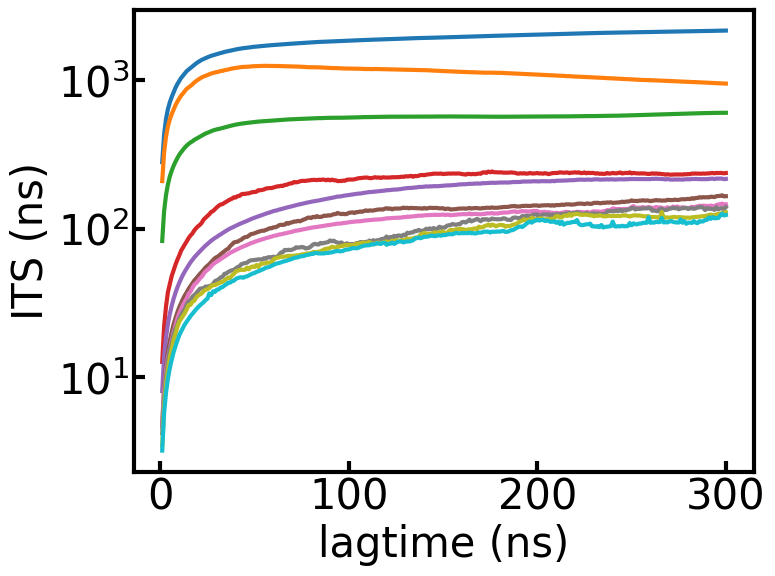

In [6]:
# ITS test

delta_t = 0.2 # ns

plt.rcParams['font.size'] = 30
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
    ax.plot(lagtime * delta_t, np.log10(micro_ITS[:,i] * delta_t), linewidth=3)

plt.yticks([1,2,3], labels=['$10^1$', '$10^2$','$10^3$'])
plt.xlabel('lagtime (ns)')
plt.ylabel('ITS (ns)')
ax.tick_params(axis='both', direction='in', width=3, length=8)
for spine in ax.spines.values():
    spine.set_linewidth(3)
# fig.legend(loc='center right', bbox_to_anchor=(1.28, 0.5))
# plt.savefig('./png/ITS_bt.png', dpi=900, bbox_inches='tight')
plt.show()